# Absentee Analysis

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('absenteeism_data.csv', sep = ';')
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


In [3]:
#checking the shape of the dataframe
print(df.shape)
#checking the columns of the dataframe
print(df.columns)
#checking the data types of the columns
print(df.dtypes)
#checking the missing values
print(df.isnull().sum())

(800, 22)
Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Seasons', 'Days since previous absence', 'Transportation expense',
       'Distance from Residence to Work', 'Estimated commute time',
       'Service time', 'Years until retirement', 'Date of Birth',
       'Disciplinary failure', 'Education', 'Number of children',
       'Social drinker', 'Social smoker', 'Number of pets', 'Weight', 'Height',
       'Body mass index', 'Absenteeism time in hours'],
      dtype='object')
ID                                   int64
Reason for absence                  object
Month of absence                    object
Day of the week                     object
Seasons                             object
Days since previous absence        float64
Transportation expense               int64
Distance from Residence to Work      int64
Estimated commute time               int64
Service time                        object
Years until retirement               int64
Date of Bi

In [4]:
#Data Preprocessing
##Removing Duplicates
# Checking duplicates before removing them
print("Before removing duplicates:", df.shape)

# find full duplicated rows 
dups = df[df.duplicated(keep=False)]
print("Duplicates found:", dups.shape[0])

# quick look at some duplicates
dups_sorted = dups.sort_values(by=df.columns.tolist())
print(dups_sorted.head(20))  

# full list (so we can check everything)
print(dups_sorted)

# check exact duplicate groups
print("Exact duplicate groups:")
print(dups.groupby(list(df.columns)).size())

# remove duplicates ( after checking)
df.drop_duplicates(inplace=True)

print("After removing duplicates:", df.shape)
print("Duplicates left:", df[df.duplicated(keep=False)].shape[0])

#Calculating age And Dropping irrelant columns ( id,years untill retirement,birth of date, weight, height,absenteeism time in hours)
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'],errors='coerce')
reference_date = datetime(2025,11,17)
df['age'] = ((reference_date - df['Date of Birth']).dt.days / 365.25).astype(int)

must_drop = ['ID','Years until retirement', 'Weight','Height', 'Absenteeism time in hours','Date of Birth']
df = df.drop(must_drop,axis=1)
#print(df.columns)

#Step 2: Handling missing values and inconsistencies
## Missing Values
#df.isna().sum()
#(df.isna().mean() * 100).sort_values(ascending=False)
  # For categorical columns
categorical_cols = [ 'Seasons', 'Month of absence', 'Reason for absence', 'Day of the week']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
# For numeric column
df['Days since previous absence'] = df['Days since previous absence'].fillna(
    df['Days since previous absence'].median())

##Handling Inconsistencies
cat_cols = ['Reason for absence', 'Month of absence', 'Day of the week','Seasons','Social smoker','Social drinker','Disciplinary failure','Education']
#for col in cat_cols:
    #print(f'\n=== {col} ===')
    #print(df[col].value_counts(dropna=False))

df['Social smoker'] = df['Social smoker'].replace({'Y': 'Yes'})
df['Social drinker'] = df['Social drinker'].replace({'Y': 'Yes'})    

#Step 3: Detect and Treat Outliers (IQR method)
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Clip outliers
df[col] = np.clip(df[col], lower_limit, upper_limit)    

#Step 4: Encoding
##Binary encoding for numeric categories
df['Social smoker'] = (df['Social smoker'] == 'Yes').astype(int)
df['Social drinker'] = (df['Social drinker'] == 'Yes').astype(int)
df['Disciplinary failure'] = df['Disciplinary failure'].astype(str).str.strip()
df['Disciplinary failure'] = pd.to_numeric(df['Disciplinary failure'], errors='coerce').fillna(0).astype(int)
df['Service time'] = df['Service time'].astype(str).str.strip()
df['Service time'] = pd.to_numeric(df['Service time'], errors='coerce').fillna(0).astype(int)

##Binary encoding for nominal categorical columns
nominal_cols = ['Reason for absence', 'Month of absence', 'Day of the week','Seasons']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
df = df.astype(int, errors='ignore')
df.dtypes

# Data Standardization
df_scaled = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
df_scaled.mean()
df_scaled.std()


Before removing duplicates: (800, 22)
Duplicates found: 48
     ID    Reason for absence Month of absence Day of the week Seasons  \
403   3         Physiotherapy         February       Wednesday  Autumn   
642   3         Physiotherapy         February       Wednesday  Autumn   
412   3         Physiotherapy         February       Wednesday     NaN   
415   3         Physiotherapy         February       Wednesday     NaN   
673   3         Physiotherapy            March       Wednesday  Autumn   
682   3         Physiotherapy            March       Wednesday  Autumn   
694   3         Physiotherapy            March       Wednesday  Autumn   
68    3                   NaN              NaN             NaN     NaN   
643   3                   NaN              NaN             NaN     NaN   
250   3                   NaN              NaN             NaN     NaN   
365   3                   NaN              NaN             NaN     NaN   
628   3                   NaN              NaN       

Days since previous absence                                                                NaN
Transportation expense                                                                     1.0
Distance from Residence to Work                                                            1.0
Estimated commute time                                                                     1.0
Service time                                                                               1.0
Disciplinary failure                                                                       NaN
Education                                                                                  1.0
Number of children                                                                         1.0
Social drinker                                                                             1.0
Social smoker                                                                              1.0
Number of pets                                    

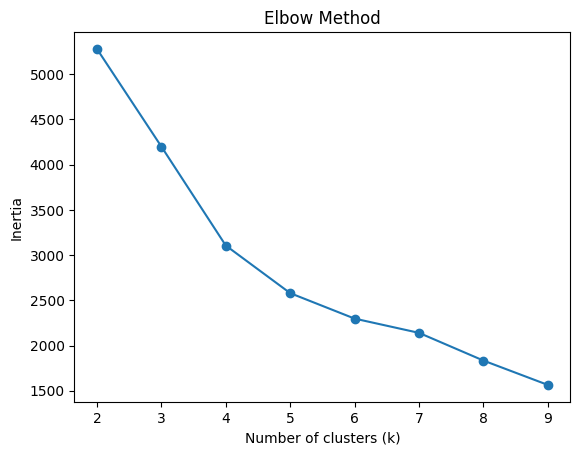

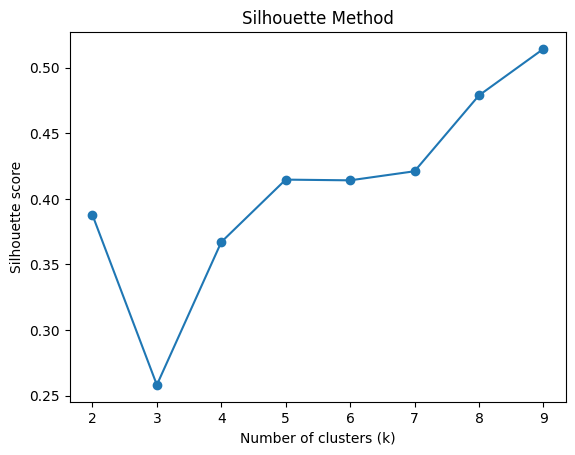

,Body mass index,Service time,Transportation expense,Distance from Residence to Work,Estimated commute time,Number of children,Number of pets,age
Cluster,,,,,,,,
0,27.973978,13.877323,184.579926,16.204461,31.684015,1.040892,0.349442,41.501859
1,25.000000,3.880952,336.452381,50.761905,107.357143,1.166667,4.785714,30.380952
2,24.233918,9.692982,251.777778,30.192982,57.561404,1.435673,0.801170,32.219298
3,31.157025,17.528926,183.545455,50.826446,107.231405,0.008264,0.090909,38.570248


In [5]:
#Clustering Analyses
segmentation_cols = ['Body mass index', 'Service time', 'Transportation expense','Distance from Residence to Work', 'Estimated commute time', 'Number of children', 'Number of pets','age']
df_cluster = df_scaled[segmentation_cols].copy()
df_cluster.head()
## Elbow Method Code
inertia = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_cluster)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

##Silhouette scores
silhouette_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster)
df['Cluster'] = df_cluster['Cluster']

df.groupby('Cluster')[segmentation_cols].mean()